# Magnetism

Magntism is only available in Refl1d and it does not support RepeatingMultilayer



## Setup
First configure matplotlib to place figures in notebook and import needed modules

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipp as sc

import easyreflectometry
import refl1d
import refl1d.names


from easyreflectometry.calculators import CalculatorFactory
from easyreflectometry.experiment import Model
from easyreflectometry.experiment import percentage_fhwm_resolution_function
from easyreflectometry.sample import Layer
from easyreflectometry.sample import Material
from easyreflectometry.sample import Multilayer
from easyreflectometry.sample import Sample

For reference we fetch the version of the software packages we are using. 

In [2]:
print(f'numpy: {np.__version__}')
print(f'scipp: {sc.__version__}')
print(f'easyreflectometry: {easyreflectometry.__version__}')
print(f'refl1d: {refl1d.__version__}')

numpy: 1.26.4
scipp: 24.02.0
easyreflectometry: 0.0.0
refl1d: 0.8.16


## Building our model

The system that was used to produce the data shown above is based on a silicon subphase with two layers upon it. 
These two layers are charachterized by having a scattering length density (SLD) of respectively 4 and 8.
Both layers have a rougness of 2 but their thicknesses are 100 and 150 angstrom respectively.
We show the model that will be used graphically below. 

<center>
    <img src='_static/two_layers.png' alt='A slab model description of the two_layers system.' width='300px'></img>
</center>
<center>
    A slab model description of the two layer.
</center>

To construct such a layer structure, first we create each of the materials, the associated layers, and the sub and super phases. 

In [3]:
sld_4 = Material(sld=4.0, isld=0, name='Sld 4')
sld_8 = Material(sld=8.0, isld=0, name='Sld 8')
vacuum = Material(sld=0, isld=0, name='Vacuum')
si = Material(sld=2.047, isld=0, name='Si')

In [4]:
sld_4_layer = Layer(material=sld_4, thickness=100, roughness=2, name='SLD 4 Layer')
sld_8_layer = Layer(material=sld_8, thickness=150, roughness=2, name='SLD 8 Layer')
superphase = Layer(material=vacuum, thickness=0, roughness=2, name='Vacuum Superphase')
subphase = Layer(material=si, thickness=0, roughness=2, name='Si Subphase')

Then, to produce the two layered structure, we use the `Multilayer` [assembly type](../sample/assemblies_library.rst#Multilayer).

In [5]:
two_layers = Multilayer([sld_4_layer, sld_8_layer], name='SLD 4/8 Layer')
two_layers

SLD 4/8 Layer:
  SLD 4 Layer/SLD 8 Layer:
  - SLD 4 Layer:
      material:
        Sld 4:
          sld: 4.000e-6 1 / angstrom ** 2
          isld: 0.000e-6 1 / angstrom ** 2
      thickness: 100.000 angstrom
      roughness: 2.000 angstrom
  - SLD 8 Layer:
      material:
        Sld 8:
          sld: 8.000e-6 1 / angstrom ** 2
          isld: 0.000e-6 1 / angstrom ** 2
      thickness: 150.000 angstrom
      roughness: 2.000 angstrom

From this, we can construct our structure and combine this with a scaling and background.

In [6]:
sample = Sample(superphase, two_layers, subphase, name='Two Layer Sample')
#sample = Sample(two_layers, subphase, name='Two Layer Sample')
#sample = Sample(two_layers, name='Two Layer Sample')
model = Model(
    sample=sample,
    scale=1,
    background=0,
    name='Two Layer Model',
)

## Prepare interface factory

We will use the [Ref1d](https://refl1d.readthedocs.io/en/latest/) and [Refnx](https://refnx.readthedocs.io/) calculator for our analysis. 

In [7]:
interface = CalculatorFactory()

## Comparisons
To validate the implementation we do some comparisons of the reflectevity determined in EasyReflectometry using different calculators or directly in Refl1d.

In [8]:

model_coords = np.linspace(
    start=0.001,
    stop=0.3,
    num=1000,
)

def plot_apply_makeup():
    ax = plt.gca()
    ax.set_xlim([-0.01, 0.35])
    ax.set_ylim([1e-7, 2.5])
    plt.legend()
    plt.yscale('log')
    plt.show()

### EasyReflectometry using the Refl1d calculator and directly in Refl1d without magnetism
First we will ensure that the Refl1d calculator is correctly implemented in EasyReflectometry when no magnetic effects are present.

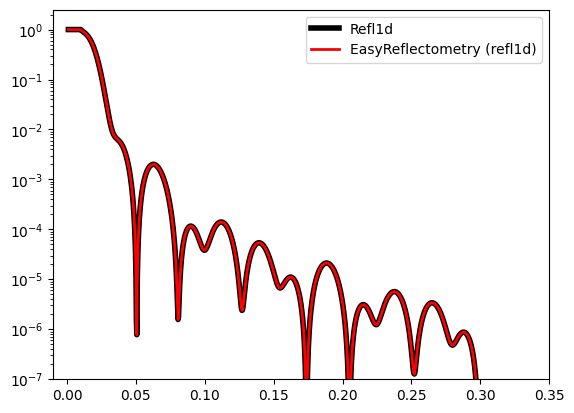

In [15]:
refl1d_sld_4 = refl1d.names.SLD(name="Sld 4", rho=4.0, irho=0)
refl1d_sld_8 = refl1d.names.SLD(name="Sld 8", rho=8.0, irho=0)
refl1d_vacuum = refl1d.names.SLD(name="Vacuum", rho=0, irho=0)
refl1d_si = refl1d.names.SLD(name="Si", rho=2.047, irho=0)

# Refl1d model is inverted as compared to EasyReflectometry, so the order of the layers is reversed
refl1d_sample = (
    refl1d_si(0, 2) | 
    refl1d_sld_8(150, 2) |
    refl1d_sld_4(100, 2) | 
    refl1d_vacuum(0, 2)
) 

probe = refl1d.names.QProbe(
        Q=model_coords,
        dQ=np.zeros(len(model_coords)),
        intensity=1,
        background=0,
    )
four_probes = [probe, None, None, None]
polarized_probe = refl1d.names.PolarizedQProbe(xs=four_probes, name='polarized')
experiment = refl1d.names.Experiment(probe=polarized_probe, sample=refl1d_sample)
model_data_no_magnetism_ref1d_raw = experiment.reflectivity()[0][1]

plt.plot(model_coords, model_data_no_magnetism_ref1d_raw, '-k', label='Refl1d', linewidth=4)

interface.switch('refl1d')
model.interface = interface
model.resolution_function = percentage_fhwm_resolution_function(0)
model_interface = model.interface()
model_data_magnetism_layer_1 = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism_layer_1, 'r-', label=f'EasyReflectometry ({model_interface.name})', linewidth=2)

plot_apply_makeup()

### Refl1d with and without magnetism, without magnetic layers
We now want to confirm that we can enable the ability to account for magnetism without causing any significant changes to the reflectivity as determined for a sample without any magnetic layers.

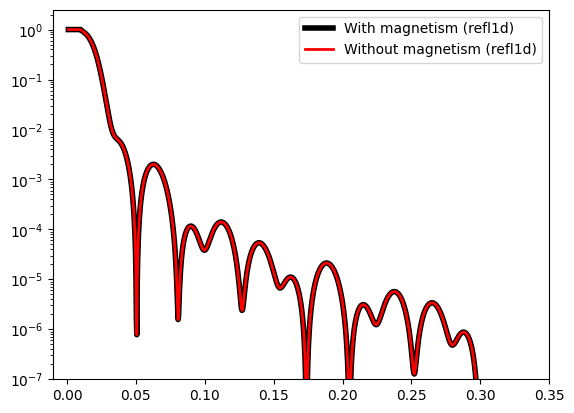

In [16]:
interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = True
model_data_magnetism = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism, '-k', label=f'With magnetism ({model_interface.name})', linewidth=4)

interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = False
model_data_no_magnetism_ref1d = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_no_magnetism_ref1d, 'r-', label=f'Without magnetism ({model_interface.name})', linewidth=2)

plot_apply_makeup()

As expected we don't see any significant change in the determined reflectivity when enabling the ability to account for magnetism.

### EasyReflectometry using Refl1d with and without magnetic layers
We have now reached the point where we can do sa simulation for a sample with magnetic layers.  For this sample we should see a difference in the determined reflectivity.

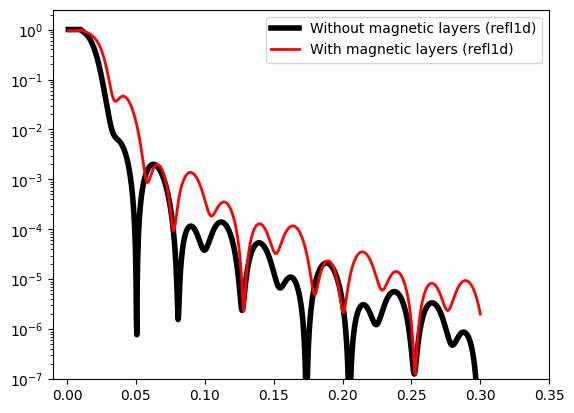

In [12]:
interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = True
model_data_magnetism = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism, '-k', label=f'Without magnetic layers ({model_interface.name})', linewidth=4)

interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = True
model_interface._wrapper.update_layer(list(model_interface._wrapper.storage['layer'].keys())[1], magnetism_rhoM=10, magnetism_thetaM=70)
model_interface._wrapper.update_layer(list(model_interface._wrapper.storage['layer'].keys())[2], magnetism_rhoM=5, magnetism_thetaM=175)
model_data_magnetism_layer_1 = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism_layer_1, 'r-', label=f'With magnetic layers ({model_interface.name})', linewidth=2)

plot_apply_makeup()

As expected do we see a difference in the reflectivity profile for a sample with and without magnetic layers.

### EasyReflectometry using the Refl1d calculator and directly in Refl1d with magnetism and magnetic layers
The final comparison is to confirm that that we are able to reproduce the raw Refl1d reflectometry in EasyReflectometry when acocunting for magnetism.

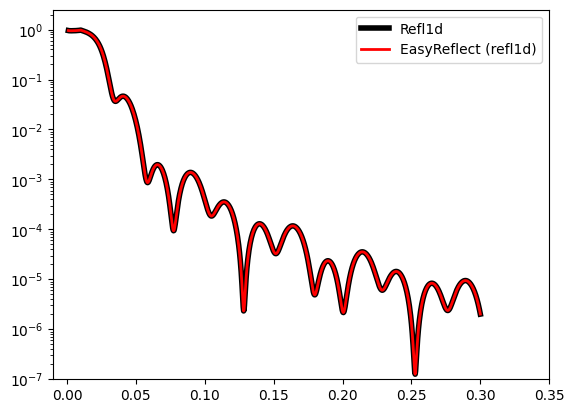

In [13]:
refl1d_sld_4 = refl1d.names.SLD(name="Sld 4", rho=4.0, irho=0)
refl1d_sld_8 = refl1d.names.SLD(name="Sld 8", rho=8.0, irho=0)
refl1d_vacuum = refl1d.names.SLD(name="Vacuum", rho=0, irho=0)
refl1d_si = refl1d.names.SLD(name="Si", rho=2.047, irho=0)

# Refl1d model is inverted as compared to EasyReflectometry, so the order of the layers is reversed
refl1d_sample = (
    refl1d_si(0, 2) | 
    refl1d_sld_8(150, 2, magnetism=refl1d.names.Magnetism(rhoM=5, thetaM=175)) |
    refl1d_sld_4(100, 2, magnetism=refl1d.names.Magnetism(rhoM=10, thetaM=70)) | 
    refl1d_vacuum(0, 2)
) 

probe = refl1d.names.QProbe(
        Q=model_coords,
        dQ=np.zeros(len(model_coords)),
        intensity=1,
        background=0,
    )
four_probes = [probe, None, None, None]
polarized_probe = refl1d.names.PolarizedQProbe(xs=four_probes, name='polarized')
experiment = refl1d.names.Experiment(probe=polarized_probe, sample=refl1d_sample)
model_data_magnetism_ref1d_raw = experiment.reflectivity()[0][1]

plt.plot(model_coords, model_data_magnetism_ref1d_raw, '-k', label='Refl1d', linewidth=4)

interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = True
model_interface._wrapper.update_layer(list(model_interface._wrapper.storage['layer'].keys())[1], magnetism_rhoM=10, magnetism_thetaM=70)
model_interface._wrapper.update_layer(list(model_interface._wrapper.storage['layer'].keys())[2], magnetism_rhoM=5, magnetism_thetaM=175)
model_data_magnetism_layer_1 = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism_layer_1, 'r-', label=f'EasyReflect ({model_interface.name})', linewidth=2)

plot_apply_makeup()

As expected do the two models agree when the magnetic parameters are the same.

# Afterthoughts 
Just for completion we should also compare the reflectivity as determined by Refl1 and Refnx in EasyReflectometry.  This study is done without magnetism as Refnx does not support this yet.

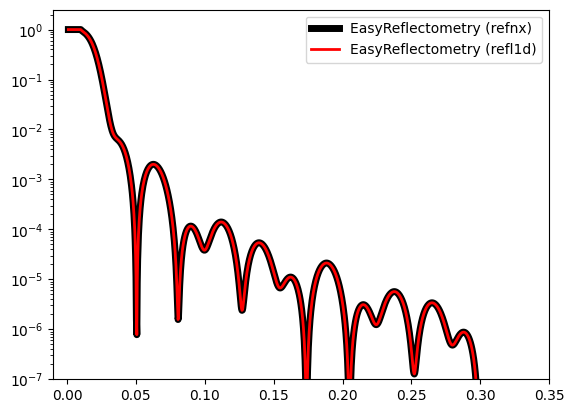

In [14]:
interface.switch('refnx')
model.interface = interface
model_interface = model.interface()
model_data_no_magnetism_refnx = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_no_magnetism_refnx, 'k-', label=f'EasyReflectometry ({model_interface.name})', linewidth=5)

interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_data_no_magnetism_ref1d = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_no_magnetism_ref1d, 'r-', label=f'EasyReflectometry ({model_interface.name})', linewidth=2)

plot_apply_makeup()